In [1]:
import pandas as pd
from collections import defaultdict
import warnings
import visualize
import neat
import multiprocessing
import os
import matplotlib.pyplot as plt

import numpy as np

from sklearn.datasets import load_digits
digits = load_digits()

In [2]:
X = digits.images.reshape(digits.images.shape[0], digits.images.shape[1] * digits.images.shape[2])[:1617]
y = digits.target[:1617]

In [3]:
necoc = 100
generations = int(500/necoc)
generations

5

In [4]:
def softmax(x, axis=1):
    # 计算每行的最大值
    row_max = x.max(axis=axis)
 
    # 每行元素都需要减去对应的最大值，否则求exp(x)会溢出，导致inf情况
    row_max=row_max.reshape(-1, 1)
    x = x - row_max
 
    # 计算e的指数次幂
    x_exp = np.exp(x)
    x_sum = np.sum(x_exp, axis=axis, keepdims=True)
    s = x_exp / x_sum
    return s

In [5]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

In [6]:
def get_winner(class1):
    
    numbers = [*range(10)] # number 2 > number 1
    number_of_classification = len(numbers)
    #number_of_sampling = 100

    list_y = y.tolist()
    digits_indexes = []
    for digit in numbers:
        li = [i for i in range(len(list_y)) if list_y[i] == digit]
        digits_indexes.extend([li])

        
    class2 = []

    class1_indexes = []
    class2_indexes = []

    for i in numbers:
        if i in class1:
            class1_indexes.extend(digits_indexes[i])
        else:
            class2_indexes.extend(digits_indexes[i])
            class2.append(i)

    class1_label = [1] * len(class1_indexes)
    class2_label = [0] * len(class2_indexes)

    print("number of class1:{}".format(len(class1_label)))
    print("number of class2:{}".format(len(class2_label)))

    samplesize = 1617
    x_inputs =[tuple(c) for c in X[class1_indexes].tolist()] + [tuple(c) for c in X[class2_indexes].tolist()]
    x_outputs = [tuple([c]) for c in class1_label + class2_label]
    
    
    def eval_genomes(genomes, config):
        for genome_id, genome in genomes:
            net = neat.nn.FeedForwardNetwork.create(genome, config)

            outputs = []
            for xi in x_inputs:
                output = net.activate(xi)
                outputs.append(output)


            px_outputs = softmax(np.array(outputs).reshape(samplesize, 2), axis=1)
            # the index of maximum in each line
            real_outputs = np.array(x_outputs).reshape(samplesize,)
            real_outputs_onehot = np.zeros(px_outputs.shape)
            for iiii in range(samplesize):
                real_outputs_onehot[iiii][real_outputs[iiii]] = 1

            ce = cross_entropy(px_outputs, real_outputs_onehot)
            fitness = 1 - ce
            genome.fitness = fitness

    def run(config_file):
        # Load configuration.
        config = neat.Config(
            neat.DefaultGenome,
            neat.DefaultReproduction,
            neat.DefaultSpeciesSet,
            neat.DefaultStagnation,
            config_file,
        )

        # Create the population, which is the top-level object for a NEAT run.
        p = neat.Population(config)

        # add a stdout reporter to show progress in the terminal
        reporter = neat.StdOutReporter(False)
        p.add_reporter(reporter)
        stats = neat.StatisticsReporter()
        p.add_reporter(stats)
        #checkpointer = neat.Checkpointer(100)
        #p.add_reporter(checkpointer)
        # Run for up to 300 generations.
        winner = p.run(eval_genomes, generations)

        return [stats, winner]
    
    local_dir = os.getcwd()
    config_path = os.path.join(local_dir, "config-feedforward-mnist2")
    [stats, winner] = run(config_path)
    
    return winner

In [7]:
import numpy as np
import random
while True:
    number_codes = []
    for i in range(2**(10-1), 2**10-1):
        for j in bin(i).split('b')[1]:
            number_codes.append(int(j))
    number_codes = np.array(number_codes).reshape(2**9 - 1,10).T     

    slice = random.sample(range(511), necoc)

    number_codes = number_codes[:,slice].tolist()

    classes = []
    for i in range(necoc):
        code_list = np.array(number_codes).T[i]
        classes.append(np.where(code_list==1)[0].tolist())

    matrix_errors = []

    for i in range(9):
        for j in range(i+1,10):
            matrix_errors.append(necoc - np.sum(np.array(number_codes[i]) == np.array(number_codes[j])))
    min_error = np.min(matrix_errors)
    if min_error != 0:
        print(min_error)
        #print(number_codes)
        break

36


In [8]:
len(number_codes[0])

100

In [9]:
winner_list = []

for i,class1 in enumerate(classes):
    print("running:{}/100".format(i))
    winner = get_winner(class1)
    winner_list.append(winner)

running:0/100
number of class1:1131
number of class2:486

 ****** Running generation 0 ****** 

Population's average fitness: 0.09216 stdev: 0.27660
Best fitness: 0.44329 - size: (2, 13) - species 2 - id 132
Average adjusted fitness: 0.651
Mean genetic distance 2.863, standard deviation 0.490
Population of 198 members in 20 species
Total extinctions: 0
Generation time: 5.150 sec

 ****** Running generation 1 ****** 

Population's average fitness: -1.03576 stdev: 2.98192
Best fitness: 0.44900 - size: (3, 15) - species 5 - id 372
Average adjusted fitness: 0.827
Mean genetic distance 2.953, standard deviation 0.500
Population of 199 members in 23 species
Total extinctions: 0
Generation time: 5.368 sec (5.259 average)

 ****** Running generation 2 ****** 

Population's average fitness: -1.59704 stdev: 3.66543
Best fitness: 0.45567 - size: (3, 14) - species 7 - id 422
Average adjusted fitness: 0.842
Mean genetic distance 2.898, standard deviation 0.503
Population of 199 members in 25 specie

Total extinctions: 0
Generation time: 5.915 sec (5.572 average)

 ****** Running generation 4 ****** 

Population's average fitness: -0.86272 stdev: 2.58441
Best fitness: 0.50834 - size: (4, 17) - species 31 - id 754
Average adjusted fitness: 0.861
Mean genetic distance 3.061, standard deviation 0.508
Population of 199 members in 33 species
Total extinctions: 0
Generation time: 6.021 sec (5.662 average)
running:5/100
number of class1:1137
number of class2:480

 ****** Running generation 0 ****** 

Population's average fitness: 0.09240 stdev: 0.26507
Best fitness: 0.58013 - size: (2, 13) - species 1 - id 139
Average adjusted fitness: 0.566
Mean genetic distance 2.860, standard deviation 0.466
Population of 200 members in 24 species
Total extinctions: 0
Generation time: 5.157 sec

 ****** Running generation 1 ****** 

Population's average fitness: -0.92798 stdev: 2.69917
Best fitness: 0.58013 - size: (2, 13) - species 1 - id 139
Average adjusted fitness: 0.839
Mean genetic distance 3.008

Total extinctions: 0
Generation time: 6.005 sec (5.631 average)

 ****** Running generation 3 ****** 

Population's average fitness: -0.94046 stdev: 3.26085
Best fitness: 0.63321 - size: (5, 19) - species 33 - id 668
Average adjusted fitness: 0.881
Mean genetic distance 3.123, standard deviation 0.476
Population of 204 members in 37 species
Total extinctions: 0
Generation time: 6.222 sec (5.779 average)

 ****** Running generation 4 ****** 

Population's average fitness: -1.30694 stdev: 4.05906
Best fitness: 0.63321 - size: (5, 19) - species 33 - id 668
Average adjusted fitness: 0.864
Mean genetic distance 3.162, standard deviation 0.486
Population of 204 members in 38 species
Total extinctions: 0
Generation time: 6.347 sec (5.893 average)
running:10/100
number of class1:646
number of class2:971

 ****** Running generation 0 ****** 

Population's average fitness: 0.07192 stdev: 0.19676
Best fitness: 0.41499 - size: (2, 13) - species 3 - id 89
Average adjusted fitness: 0.475
Mean geneti

Population's average fitness: -1.68266 stdev: 3.26238
Best fitness: 0.38797 - size: (3, 15) - species 4 - id 473
Average adjusted fitness: 0.710
Mean genetic distance 2.957, standard deviation 0.465
Population of 206 members in 29 species
Total extinctions: 0
Generation time: 5.979 sec (6.361 average)

 ****** Running generation 3 ****** 

Population's average fitness: -1.28745 stdev: 3.03595
Best fitness: 0.38797 - size: (3, 15) - species 4 - id 473
Average adjusted fitness: 0.769
Mean genetic distance 2.960, standard deviation 0.501
Population of 203 members in 33 species
Total extinctions: 0
Generation time: 6.214 sec (6.324 average)

 ****** Running generation 4 ****** 

Population's average fitness: -1.40930 stdev: 3.09619
Best fitness: 0.41078 - size: (3, 16) - species 4 - id 847
Average adjusted fitness: 0.752
Mean genetic distance 3.028, standard deviation 0.492
Population of 197 members in 34 species
Total extinctions: 0
Generation time: 6.210 sec (6.301 average)
running:15/10

Population's average fitness: -1.25679 stdev: 3.07235
Best fitness: 0.49939 - size: (3, 13) - species 18 - id 302
Average adjusted fitness: 0.848
Mean genetic distance 2.988, standard deviation 0.489
Population of 198 members in 31 species
Total extinctions: 0
Generation time: 8.499 sec (7.218 average)

 ****** Running generation 2 ****** 

Population's average fitness: -1.20079 stdev: 2.88668
Best fitness: 0.49939 - size: (3, 13) - species 18 - id 302
Average adjusted fitness: 0.851
Mean genetic distance 3.024, standard deviation 0.489
Population of 198 members in 34 species
Total extinctions: 0
Generation time: 7.674 sec (7.370 average)

 ****** Running generation 3 ****** 

Population's average fitness: -1.17191 stdev: 2.91305
Best fitness: 0.49939 - size: (3, 13) - species 18 - id 302
Average adjusted fitness: 0.800
Mean genetic distance 3.108, standard deviation 0.489
Population of 203 members in 36 species
Total extinctions: 0
Generation time: 6.583 sec (7.174 average)

 ****** R

Population's average fitness: 0.10840 stdev: 0.17632
Best fitness: 0.42988 - size: (2, 13) - species 1 - id 84
Average adjusted fitness: 0.491
Mean genetic distance 3.021, standard deviation 0.495
Population of 200 members in 34 species
Total extinctions: 0
Generation time: 9.357 sec

 ****** Running generation 1 ****** 

Population's average fitness: -1.11986 stdev: 2.75862
Best fitness: 0.47679 - size: (3, 14) - species 1 - id 349
Average adjusted fitness: 0.831
Mean genetic distance 3.024, standard deviation 0.488
Population of 203 members in 35 species
Total extinctions: 0
Generation time: 7.747 sec (8.552 average)

 ****** Running generation 2 ****** 

Population's average fitness: -1.38245 stdev: 2.99884
Best fitness: 0.47679 - size: (3, 14) - species 1 - id 349
Average adjusted fitness: 0.847
Mean genetic distance 3.021, standard deviation 0.517
Population of 204 members in 35 species
Total extinctions: 0
Generation time: 8.693 sec (8.599 average)

 ****** Running generation 3 *

Population's average fitness: -1.03496 stdev: 2.80053
Best fitness: 0.46787 - size: (2, 14) - species 8 - id 368
Average adjusted fitness: 0.899
Mean genetic distance 3.113, standard deviation 0.499
Population of 195 members in 39 species
Total extinctions: 0
Generation time: 15.940 sec (13.591 average)
running:29/100
number of class1:810
number of class2:807

 ****** Running generation 0 ****** 

Population's average fitness: 0.09869 stdev: 0.14835
Best fitness: 0.36466 - size: (2, 13) - species 3 - id 129
Average adjusted fitness: 0.347
Mean genetic distance 2.807, standard deviation 0.449
Population of 200 members in 18 species
Total extinctions: 0
Generation time: 13.020 sec

 ****** Running generation 1 ****** 

Population's average fitness: -1.21701 stdev: 2.85220
Best fitness: 0.37895 - size: (2, 14) - species 3 - id 326
Average adjusted fitness: 0.761
Mean genetic distance 2.951, standard deviation 0.481
Population of 201 members in 22 species
Total extinctions: 0
Generation ti

Mean genetic distance 3.081, standard deviation 0.491
Population of 204 members in 44 species
Total extinctions: 0
Generation time: 15.032 sec (14.110 average)

 ****** Running generation 3 ****** 

Population's average fitness: -1.53725 stdev: 3.11855
Best fitness: 0.41888 - size: (2, 14) - species 41 - id 563
Average adjusted fitness: 0.810
Mean genetic distance 3.043, standard deviation 0.489
Population of 206 members in 44 species
Total extinctions: 0
Generation time: 15.139 sec (14.368 average)

 ****** Running generation 4 ****** 

Population's average fitness: -1.24051 stdev: 2.97941
Best fitness: 0.41888 - size: (2, 14) - species 41 - id 563
Average adjusted fitness: 0.837
Mean genetic distance 3.050, standard deviation 0.489
Population of 201 members in 44 species
Total extinctions: 0
Generation time: 15.520 sec (14.598 average)
running:34/100
number of class1:970
number of class2:647

 ****** Running generation 0 ****** 

Population's average fitness: 0.10111 stdev: 0.16005
B

Population's average fitness: -1.18162 stdev: 2.91276
Best fitness: 0.42472 - size: (2, 13) - species 1 - id 8
Average adjusted fitness: 0.854
Mean genetic distance 3.041, standard deviation 0.493
Population of 200 members in 28 species
Total extinctions: 0
Generation time: 14.287 sec (14.178 average)

 ****** Running generation 2 ****** 

Population's average fitness: -1.19364 stdev: 3.06501
Best fitness: 0.43549 - size: (4, 18) - species 21 - id 481
Average adjusted fitness: 0.866
Mean genetic distance 3.075, standard deviation 0.479
Population of 201 members in 32 species
Total extinctions: 0
Generation time: 15.353 sec (14.570 average)

 ****** Running generation 3 ****** 

Population's average fitness: -1.14931 stdev: 3.12725
Best fitness: 0.43815 - size: (5, 18) - species 9 - id 662
Average adjusted fitness: 0.841
Mean genetic distance 3.130, standard deviation 0.484
Population of 200 members in 34 species
Total extinctions: 0
Generation time: 15.536 sec (14.811 average)

 ******

Mean genetic distance 3.160, standard deviation 0.473
Population of 205 members in 48 species
Total extinctions: 0
Generation time: 15.901 sec (14.696 average)
running:43/100
number of class1:650
number of class2:967

 ****** Running generation 0 ****** 

Population's average fitness: 0.07812 stdev: 0.18876
Best fitness: 0.37329 - size: (2, 13) - species 3 - id 59
Average adjusted fitness: 0.460
Mean genetic distance 2.942, standard deviation 0.482
Population of 201 members in 25 species
Total extinctions: 0
Generation time: 13.001 sec

 ****** Running generation 1 ****** 

Population's average fitness: -1.22788 stdev: 3.07837
Best fitness: 0.38879 - size: (3, 15) - species 5 - id 300
Average adjusted fitness: 0.823
Mean genetic distance 2.992, standard deviation 0.466
Population of 202 members in 29 species
Total extinctions: 0
Generation time: 13.956 sec (13.478 average)

 ****** Running generation 2 ****** 

Population's average fitness: -1.09922 stdev: 2.74941
Best fitness: 0.40291

Population's average fitness: -1.25329 stdev: 3.05003
Best fitness: 0.42891 - size: (3, 15) - species 11 - id 236
Average adjusted fitness: 0.822
Mean genetic distance 3.107, standard deviation 0.473
Population of 201 members in 34 species
Total extinctions: 0
Generation time: 15.052 sec (14.312 average)

 ****** Running generation 4 ****** 

Population's average fitness: -1.28904 stdev: 2.99824
Best fitness: 0.46325 - size: (3, 15) - species 13 - id 812
Average adjusted fitness: 0.807
Mean genetic distance 3.077, standard deviation 0.484
Population of 202 members in 34 species
Total extinctions: 0
Generation time: 15.804 sec (14.610 average)
running:48/100
number of class1:970
number of class2:647

 ****** Running generation 0 ****** 

Population's average fitness: 0.10653 stdev: 0.17373
Best fitness: 0.38872 - size: (2, 13) - species 8 - id 189
Average adjusted fitness: 0.426
Mean genetic distance 2.986, standard deviation 0.558
Population of 201 members in 22 species
Total extinctio

Mean genetic distance 3.107, standard deviation 0.491
Population of 202 members in 35 species
Total extinctions: 0
Generation time: 15.808 sec (14.490 average)

 ****** Running generation 2 ****** 

Population's average fitness: -1.70241 stdev: 3.66484
Best fitness: 0.41272 - size: (2, 14) - species 20 - id 284
Average adjusted fitness: 0.842
Mean genetic distance 3.150, standard deviation 0.501
Population of 204 members in 39 species
Total extinctions: 0
Generation time: 14.997 sec (14.659 average)

 ****** Running generation 3 ****** 

Population's average fitness: -1.25890 stdev: 3.08364
Best fitness: 0.46246 - size: (3, 15) - species 26 - id 659
Average adjusted fitness: 0.843
Mean genetic distance 3.181, standard deviation 0.502
Population of 204 members in 41 species
Total extinctions: 0
Generation time: 15.770 sec (14.937 average)

 ****** Running generation 4 ****** 

Population's average fitness: -1.34023 stdev: 3.20073
Best fitness: 0.46690 - size: (4, 16) - species 26 - id 8

Population's average fitness: 0.12895 stdev: 0.16191
Best fitness: 0.42698 - size: (2, 13) - species 1 - id 80
Average adjusted fitness: 0.373
Mean genetic distance 2.894, standard deviation 0.471
Population of 199 members in 19 species
Total extinctions: 0
Generation time: 14.524 sec

 ****** Running generation 1 ****** 

Population's average fitness: -1.15345 stdev: 2.76725
Best fitness: 0.48456 - size: (3, 15) - species 7 - id 273
Average adjusted fitness: 0.737
Mean genetic distance 2.966, standard deviation 0.485
Population of 202 members in 24 species
Total extinctions: 0
Generation time: 15.271 sec (14.897 average)

 ****** Running generation 2 ****** 

Population's average fitness: -1.51252 stdev: 3.14076
Best fitness: 0.48456 - size: (3, 15) - species 7 - id 273
Average adjusted fitness: 0.729
Mean genetic distance 3.034, standard deviation 0.470
Population of 204 members in 32 species
Total extinctions: 0
Generation time: 16.299 sec (15.365 average)

 ****** Running generatio

Mean genetic distance 3.042, standard deviation 0.494
Population of 205 members in 32 species
Total extinctions: 0
Generation time: 15.961 sec (15.172 average)

 ****** Running generation 4 ****** 

Population's average fitness: -1.16980 stdev: 2.93481
Best fitness: 0.47977 - size: (2, 14) - species 18 - id 824
Average adjusted fitness: 0.805
Mean genetic distance 3.042, standard deviation 0.532
Population of 202 members in 32 species
Total extinctions: 0
Generation time: 16.907 sec (15.519 average)
running:62/100
number of class1:1129
number of class2:488

 ****** Running generation 0 ****** 

Population's average fitness: 0.08332 stdev: 0.25601
Best fitness: 0.46486 - size: (2, 13) - species 1 - id 154
Average adjusted fitness: 0.606
Mean genetic distance 2.907, standard deviation 0.473
Population of 201 members in 27 species
Total extinctions: 0
Generation time: 14.173 sec

 ****** Running generation 1 ****** 

Population's average fitness: -1.30364 stdev: 3.26417
Best fitness: 0.51

Population's average fitness: -1.18684 stdev: 3.22736
Best fitness: 0.47443 - size: (2, 12) - species 26 - id 346
Average adjusted fitness: 0.866
Mean genetic distance 3.096, standard deviation 0.503
Population of 201 members in 35 species
Total extinctions: 0
Generation time: 15.767 sec (15.128 average)

 ****** Running generation 3 ****** 

Population's average fitness: -1.01814 stdev: 2.75432
Best fitness: 0.48385 - size: (4, 15) - species 3 - id 566
Average adjusted fitness: 0.879
Mean genetic distance 3.087, standard deviation 0.510
Population of 202 members in 35 species
Total extinctions: 0
Generation time: 16.338 sec (15.430 average)

 ****** Running generation 4 ****** 

Population's average fitness: -1.12079 stdev: 2.78119
Best fitness: 0.48385 - size: (4, 15) - species 3 - id 566
Average adjusted fitness: 0.876
Mean genetic distance 3.118, standard deviation 0.508
Population of 199 members in 36 species
Total extinctions: 0
Generation time: 16.661 sec (15.676 average)
runnin

Mean genetic distance 2.958, standard deviation 0.479
Population of 200 members in 25 species
Total extinctions: 0
Generation time: 14.429 sec

 ****** Running generation 1 ****** 

Population's average fitness: -1.05953 stdev: 2.79730
Best fitness: 0.54702 - size: (2, 14) - species 4 - id 382
Average adjusted fitness: 0.803
Mean genetic distance 2.988, standard deviation 0.477
Population of 202 members in 30 species
Total extinctions: 0
Generation time: 15.100 sec (14.765 average)

 ****** Running generation 2 ****** 

Population's average fitness: -1.39598 stdev: 3.11796
Best fitness: 0.54702 - size: (2, 14) - species 4 - id 382
Average adjusted fitness: 0.823
Mean genetic distance 2.966, standard deviation 0.472
Population of 203 members in 32 species
Total extinctions: 0
Generation time: 15.851 sec (15.127 average)

 ****** Running generation 3 ****** 

Population's average fitness: -1.02435 stdev: 2.79774
Best fitness: 0.54702 - size: (2, 14) - species 4 - id 382
Average adjusted 

Population's average fitness: -1.83135 stdev: 3.33543
Best fitness: 0.45972 - size: (4, 17) - species 32 - id 828
Average adjusted fitness: 0.765
Mean genetic distance 3.176, standard deviation 0.479
Population of 210 members in 44 species
Total extinctions: 0
Generation time: 17.658 sec (16.113 average)
running:76/100
number of class1:486
number of class2:1131

 ****** Running generation 0 ****** 

Population's average fitness: 0.09534 stdev: 0.23933
Best fitness: 0.47523 - size: (2, 13) - species 1 - id 9
Average adjusted fitness: 0.657
Mean genetic distance 2.923, standard deviation 0.447
Population of 201 members in 26 species
Total extinctions: 0
Generation time: 14.220 sec

 ****** Running generation 1 ****** 

Population's average fitness: -1.22208 stdev: 3.16767
Best fitness: 0.49975 - size: (2, 14) - species 5 - id 249
Average adjusted fitness: 0.812
Mean genetic distance 2.974, standard deviation 0.475
Population of 203 members in 29 species
Total extinctions: 0
Generation ti

Mean genetic distance 3.017, standard deviation 0.486
Population of 201 members in 31 species
Total extinctions: 0
Generation time: 15.402 sec (14.918 average)

 ****** Running generation 3 ****** 

Population's average fitness: -1.41301 stdev: 3.07916
Best fitness: 0.39167 - size: (4, 15) - species 3 - id 660
Average adjusted fitness: 0.811
Mean genetic distance 3.045, standard deviation 0.483
Population of 203 members in 33 species
Total extinctions: 0
Generation time: 16.128 sec (15.220 average)

 ****** Running generation 4 ****** 

Population's average fitness: -0.96755 stdev: 2.71893
Best fitness: 0.39167 - size: (4, 15) - species 3 - id 660
Average adjusted fitness: 0.855
Mean genetic distance 3.115, standard deviation 0.491
Population of 205 members in 34 species
Total extinctions: 0
Generation time: 16.825 sec (15.541 average)
running:81/100
number of class1:487
number of class2:1130

 ****** Running generation 0 ****** 

Population's average fitness: 0.11356 stdev: 0.24041
Be

Population's average fitness: -1.16694 stdev: 2.89182
Best fitness: 0.38226 - size: (2, 13) - species 7 - id 185
Average adjusted fitness: 0.809
Mean genetic distance 3.002, standard deviation 0.508
Population of 199 members in 29 species
Total extinctions: 0
Generation time: 15.239 sec (14.780 average)

 ****** Running generation 2 ****** 

Population's average fitness: -1.15420 stdev: 2.76918
Best fitness: 0.39183 - size: (2, 12) - species 3 - id 518
Average adjusted fitness: 0.821
Mean genetic distance 3.053, standard deviation 0.517
Population of 200 members in 33 species
Total extinctions: 0
Generation time: 15.850 sec (15.137 average)

 ****** Running generation 3 ****** 

Population's average fitness: -1.22839 stdev: 3.09695
Best fitness: 0.39183 - size: (2, 12) - species 3 - id 518
Average adjusted fitness: 0.798
Mean genetic distance 3.065, standard deviation 0.506
Population of 196 members in 35 species
Total extinctions: 0
Generation time: 16.403 sec (15.453 average)

 *****

Mean genetic distance 3.138, standard deviation 0.503
Population of 202 members in 43 species
Total extinctions: 0
Generation time: 17.004 sec (15.819 average)
running:90/100
number of class1:322
number of class2:1295

 ****** Running generation 0 ****** 

Population's average fitness: 0.08936 stdev: 0.33961
Best fitness: 0.61297 - size: (2, 13) - species 3 - id 40
Average adjusted fitness: 0.599
Mean genetic distance 2.939, standard deviation 0.460
Population of 199 members in 27 species
Total extinctions: 0
Generation time: 14.503 sec

 ****** Running generation 1 ****** 

Population's average fitness: -0.67268 stdev: 2.68407
Best fitness: 0.61297 - size: (2, 13) - species 3 - id 40
Average adjusted fitness: 0.868
Mean genetic distance 2.983, standard deviation 0.480
Population of 200 members in 32 species
Total extinctions: 0
Generation time: 15.090 sec (14.797 average)

 ****** Running generation 2 ****** 

Population's average fitness: -1.71676 stdev: 4.19879
Best fitness: 0.61297

Population's average fitness: -1.35722 stdev: 3.04302
Best fitness: 0.45490 - size: (2, 13) - species 27 - id 51
Average adjusted fitness: 0.831
Mean genetic distance 3.043, standard deviation 0.479
Population of 206 members in 29 species
Total extinctions: 0
Generation time: 16.912 sec (15.647 average)

 ****** Running generation 4 ****** 

Population's average fitness: -1.12857 stdev: 2.97436
Best fitness: 0.47220 - size: (3, 14) - species 27 - id 835
Average adjusted fitness: 0.853
Mean genetic distance 3.054, standard deviation 0.485
Population of 202 members in 29 species
Total extinctions: 0
Generation time: 17.021 sec (15.922 average)
running:95/100
number of class1:1291
number of class2:326

 ****** Running generation 0 ****** 

Population's average fitness: 0.11302 stdev: 0.33860
Best fitness: 0.55324 - size: (2, 13) - species 3 - id 139
Average adjusted fitness: 0.627
Mean genetic distance 2.963, standard deviation 0.497
Population of 201 members in 30 species
Total extinctio

Mean genetic distance 2.941, standard deviation 0.455
Population of 199 members in 25 species
Total extinctions: 0
Generation time: 15.294 sec (14.821 average)

 ****** Running generation 2 ****** 

Population's average fitness: -0.60670 stdev: 3.02976
Best fitness: 0.73502 - size: (4, 16) - species 21 - id 522
Average adjusted fitness: 0.915
Mean genetic distance 2.962, standard deviation 0.455
Population of 199 members in 30 species
Total extinctions: 0
Generation time: 15.633 sec (15.092 average)

 ****** Running generation 3 ****** 

Population's average fitness: -0.74600 stdev: 3.62565
Best fitness: 0.73502 - size: (4, 16) - species 21 - id 522
Average adjusted fitness: 0.913
Mean genetic distance 3.027, standard deviation 0.462
Population of 205 members in 30 species
Total extinctions: 0
Generation time: 16.321 sec (15.399 average)

 ****** Running generation 4 ****** 

Population's average fitness: -0.44928 stdev: 2.85230
Best fitness: 0.73502 - size: (4, 16) - species 21 - id 5

In [10]:
len(winner_list)

100

In [11]:
local_dir = os.getcwd()
config_path = os.path.join(local_dir, "config-feedforward-mnist2")

config = neat.Config(
    neat.DefaultGenome,
    neat.DefaultReproduction,
    neat.DefaultSpeciesSet,
    neat.DefaultStagnation,
    config_path,
)

In [12]:
def get_pred_real(i, j):
    winner_net = neat.nn.FeedForwardNetwork.create(winner_list[i], config)
    
    numbers = [*range(10)]
    class1 = classes[i]
    class2 = []
    class1_indexes = []
    class2_indexes = []
    
    test_X = digits.images.reshape(digits.images.shape[0], digits.images.shape[1] * digits.images.shape[2])[j]
    test_y = digits.target[j]

    list_y = [test_y]
    digits_indexes = []
    for digit in numbers:
        li = [i for i in range(len(list_y)) if list_y[i] == digit]
        digits_indexes.extend([li])

    for i in numbers:
        if i in class1:
            class1_indexes.extend(digits_indexes[i])
        else:
            class2_indexes.extend(digits_indexes[i])
            class2.append(i)

    class1_label = [1] * len(class1_indexes)
    class2_label = [0] * len(class2_indexes)


    testsamplesize = 1
    test_x_inputs =[tuple(test_X)]
    test_x_outputs = [tuple([c]) for c in class1_label + class2_label]

    outputs = []
    for xi in test_x_inputs:
        output = winner_net.activate(xi)
        outputs.append(output)

    px_outputs = softmax(np.array(outputs).reshape(testsamplesize, 2), axis=1)
    # the index of maximum in each line
    pred_outputs = np.argmax(px_outputs, axis = 1)
    real_outputs = np.array(test_x_outputs).reshape(testsamplesize,)

    
    return [pred_outputs, real_outputs]

In [13]:
from random import randint
pred_value = []
error_list = []

for j in range(1617,1617+180):
    pred = []
    for i in range(necoc):
        [pred_outputs, real_outputs] = get_pred_real(i, j)
        #print(pred_outputs, real_outputs)
        pred.append(pred_outputs)
    #print(np.array(pred).T)
    
    error = []
    for i in range(10):
        error.append(necoc - np.sum(number_codes[i] == np.array(pred).T))
    #print(error)
    
    pred_value.append(np.where(error==np.min(error)))
    error_list.append(np.min(error))
    #print(np.where(error==np.min(error)) )
list_P = []
for i in pred_value:
    if (len(i[0])) == 1:
        list_P.append(i[0][0])
    else:
        random_pick = randint(0, len(i[0])-1)
        list_P.append(i[0][random_pick])
np.sum(list_P == digits.target[1617:])/180

0.7055555555555556

In [14]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(list_P, digits.target[1617:])
print(cm)

[[12  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0 13  0  0  0  0  0  0  0]
 [ 0  0  1 13  0  0  0  0  4  9]
 [ 1 13  0  0 18  0  0  2  1  0]
 [ 2  0  0  0  0 18  0  0  0  0]
 [ 1  0  2  0  0  0 18  0  1  0]
 [ 0  0  0  1  1  0  0 17  0  1]
 [ 0  6  1  4  0  0  0  0 11  1]
 [ 0  0  0  0  1  0  0  0  0  7]]


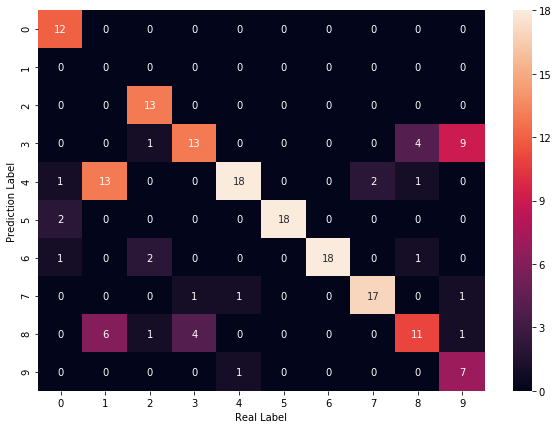

In [15]:
import seaborn as sn


df_cm = pd.DataFrame(cm, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Real Label')
plt.ylabel('Prediction Label')
plt.show()

In [16]:
list_P = []
for i,p_value in enumerate(pred_value):
    print("#{} min_error:{} index:{} real:{}".format(i, error_list[i], p_value[0], digits.target[1617+i]))

#0 min_error:25 index:[5] real:5
#1 min_error:32 index:[3] real:2
#2 min_error:30 index:[8] real:8
#3 min_error:27 index:[0] real:0
#4 min_error:30 index:[4] real:1
#5 min_error:27 index:[7] real:7
#6 min_error:19 index:[6] real:6
#7 min_error:19 index:[3] real:3
#8 min_error:23 index:[2] real:2
#9 min_error:37 index:[2 4] real:1
#10 min_error:34 index:[4 7] real:7
#11 min_error:30 index:[7] real:4
#12 min_error:25 index:[6] real:6
#13 min_error:24 index:[3] real:3
#14 min_error:31 index:[4] real:1
#15 min_error:24 index:[3] real:3
#16 min_error:30 index:[7] real:9
#17 min_error:29 index:[4] real:1
#18 min_error:33 index:[7] real:7
#19 min_error:15 index:[6] real:6
#20 min_error:31 index:[8] real:8
#21 min_error:24 index:[4] real:4
#22 min_error:18 index:[3] real:3
#23 min_error:32 index:[4] real:1
#24 min_error:19 index:[4] real:4
#25 min_error:31 index:[0] real:0
#26 min_error:23 index:[5] real:5
#27 min_error:15 index:[3] real:3
#28 min_error:29 index:[6] real:6
#29 min_error:25 ind

In [17]:
pred_value = []
error_list = []

for j in range(1617):
    pred = []
    for i in range(necoc):
        [pred_outputs, real_outputs] = get_pred_real(i, j)
        #print(pred_outputs, real_outputs)
        pred.append(pred_outputs)
    #print(np.array(pred).T)
    
    error = []
    for i in range(10):
        error.append(10 - np.sum(number_codes[i] == np.array(pred).T))
    #print(error)
    
    pred_value.append(np.where(error==np.min(error)))
    error_list.append(np.min(error))
    #print(np.where(error==np.min(error)) )

list_P = []
for i in pred_value:
    if (len(i[0])) == 1:
        list_P.append(i[0][0])
    else:
        random_pick = randint(0, len(i[0])-1)
        list_P.append(i[0][random_pick])
print("Testset acc:{}".format(np.sum(list_P == digits.target[:1617])/1617))
winner_fitness = []
for winner in winner_list:
    #print(winner.fitness)
    winner_fitness.append(winner.fitness)
print("Avg Base Learner:{}".format(np.mean(winner_fitness)))

Testset acc:0.7779839208410637
Avg Base Learner:0.4854386425928589


In [18]:
from random import randint

list_acc = []

for iii in range(necoc):
    pred_value = []
    error_list = []


    for j in range(1617,1617+180):
        pred = []
        for i in range(iii):
            [pred_outputs, real_outputs] = get_pred_real(i, j)
            #print(pred_outputs, real_outputs)
            pred.append(pred_outputs)
        #print(np.array(pred).T)

        error = []
        for i in range(10):
            error.append(iii - np.sum(number_codes[i][:iii] == np.array(pred).T))
        #print(error)

        pred_value.append(np.where(error==np.min(error)))
        error_list.append(np.min(error))
        #print(np.where(error==np.min(error)) )
    list_P = []
    for i in pred_value:
        if (len(i[0])) == 1:
            list_P.append(i[0][0])
        else:
            random_pick = randint(0, len(i[0])-1)
            list_P.append(i[0][random_pick])
    acc = np.sum(list_P == digits.target[1617:])/180
    #print("Accuracy on training set: {}".format(acc))
    list_acc.append(acc)

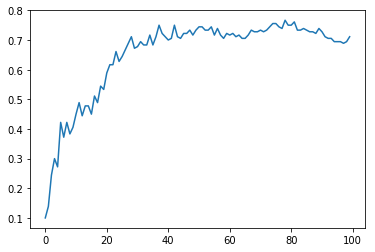

In [19]:
plt.plot(range(necoc),list_acc)
plt.show()

In [20]:
# program to check if there is exist a path between two vertices 
# of a graph 

from collections import defaultdict 

#This class represents a directed graph using adjacency list representation 
class Graph: 

	def __init__(self,vertices): 
		self.V= vertices #No. of vertices 
		self.graph = defaultdict(list) # default dictionary to store graph 

	# function to add an edge to graph 
	def addEdge(self,u,v): 
		self.graph[u].append(v) 
	
	# Use BFS to check path between s and d 
	def isReachable(self, s, d): 
		# Mark all the vertices as not visited 
		visited =[False]*(self.V) 

		# Create a queue for BFS 
		queue=[] 

		# Mark the source node as visited and enqueue it 
		queue.append(s) 
		visited[s] = True

		while queue: 

			#Dequeue a vertex from queue 
			n = queue.pop(0) 
			
			# If this adjacent node is the destination node, 
			# then return true 
			if n == d: 
				return True

			# Else, continue to do BFS 
			for i in self.graph[n]: 
				if visited[i] == False: 
					queue.append(i) 
					visited[i] = True
		# If BFS is complete without visited d 
		return False
    
    
def findAllPath(graph,start,end,path=[]):
    path = path +[start]
    if start == end:
        return [path]
 
    paths = [] #存储所有路径    
    for node in graph[start]:
        if node not in path:
            newpaths = findAllPath(graph,node,end,path) 
            for newpath in newpaths:
                paths.append(newpath)
    return paths

numbers = [*range(2)]
number_of_classification = len(numbers)

list_nodes_number = []
list_connection_number = []

for winner in winner_list:
    used_nodes = list(winner.nodes.keys())
    # create a dict for mapping 
    l1 = numbers + config.genome_config.input_keys + used_nodes[number_of_classification:]
    l2 = range(len(l1))
    dict_nodes = dict(zip(l1, l2))

    ### 将节点加入图
    g = Graph(len(l1))# inputs + outputs + used  
    # add connections in the graph
    for cg in winner.connections.values():
        if cg.enabled:
            g.addEdge(dict_nodes[cg.key[0]],dict_nodes[cg.key[1]])

    v = numbers
    list_connections = []
    for vi in v:
        for u in range(number_of_classification, len(config.genome_config.input_keys) + number_of_classification):
            list_connections.append(g.isReachable(u, vi))

    nodes_inputs = range(number_of_classification, number_of_classification+ 64)
    nodes_outputs = range(number_of_classification)
    nodes_mid = range(number_of_classification + 64, len(dict_nodes))

    # 找到所有输入和输出连接的路
    all_path = []
    for u in nodes_inputs:
        for v in nodes_outputs:
            path = findAllPath(g.graph, u, v)
            if path:
                all_path = all_path + path

    # 得到最长路，以及每个节点在哪个层级
    max_length = max([len(x) for x in all_path])
    nodes_tuples_list = []
    for path in all_path:
        #print(path)
        for node in path:
            nodes_tuples_list.append([node, path.index(node)])

    # 确定节点的层级（消除重复）       
    nodes_tuples_fixed_list = []
    for index in range(max_length):
        for nodes in nodes_tuples_list:
            node, node_index = nodes[0], nodes[1]
            if node_index == index: 
                if nodes not in nodes_tuples_fixed_list:
                    nodes_tuples_fixed_list.append(nodes)


    # 所有有连接的节点
    all_used_nodes = []
    for node in nodes_tuples_fixed_list:
        if node[0] not in all_used_nodes:
            all_used_nodes.append(node[0])

    # 确定节点的层级（最终确定）
    nodes_tuples_fixed_list_final = []

    for node in all_used_nodes:
        if node in nodes_inputs:
            nodes_tuples_fixed_list_final.append([node, 0])
        elif node in nodes_outputs:
            nodes_tuples_fixed_list_final.append([node, max_length - 1])
        else:
            list_node = []
            for nodes in nodes_tuples_fixed_list:
                if node == nodes[0]:
                    list_node.append(nodes)
            layer = 0
            for ele in list_node:
                # 删除重复项，取最大
                if ele[1] > layer:
                    layer = ele[1]
            nodes_tuples_fixed_list_final.append([node,layer])


    # 每个层级的节点合数
    length_of_layers = []
    number_of_nodes = 0
    for index in range(max_length):
        for nodes in nodes_tuples_fixed_list_final:
            node, node_index = nodes[0], nodes[1]
            if node_index == index: 
                number_of_nodes += 1
        length_of_layers.append(number_of_nodes)

    length_of_each_layer = []
    length_of_each_layer.append(length_of_layers[0])
    for i in range(1, max_length):
        length_of_each_layer.append(length_of_layers[i] - length_of_layers[i-1])

    # 输出每个层级的节点个数
    #print("length of each layers:", length_of_each_layer)

    # 所有端到端的路
    all_path_side2side = []
    for path in all_path:
        if len(path) == 2:
            all_path_side2side.append(path)
        else:
            for i in range(len(path)-1):
                all_path_side2side.append([path[i],path[i+1]])

    # 定义节点到绘图的字典
    dict_nodes_graph = dict()
    count_number_layer = [0] * max_length
    for nodes in nodes_tuples_fixed_list_final:
        node, layer = nodes
        dict_nodes_graph[node] = [count_number_layer[layer], layer]
        count_number_layer[layer] += 1
    list_nodes_number.append(np.sum(length_of_each_layer))
    list_connection_number.append(len(all_path_side2side))
    #print("Number of nodes:{} Number of connections:{}".format(np.sum(length_of_each_layer),len(all_path_side2side)))
print("Total nodes:{} Total connections::{}".format(np.sum(list_nodes_number), np.sum(list_connection_number)))

Total nodes:1600 Total connections::1537
